In [1]:
# Import the relevant libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import statsmodels.api as sm
from pandas_datareader import data as pdr
from sklearn.linear_model import LinearRegression
# Prettier graphs.
sns.set()

## Getting the data:

In [2]:
# First off lets get the petrol price data.
# This can be obtained via the Australian Institute of Petroleum website.
# It is in a excel file on page 2.
petrol_df = pd.read_excel(io = "https://www.aip.com.au/sites/default/files/download-files/2022-02/AIP_TGP_Data_11-Feb-2022.xlsx", sheet_name = "Petrol TGP")
petrol_df.head()

,AVERAGE ULP TGPS\n(inclusive of GST),Sydney,Melbourne,Brisbane,Adelaide,Perth,Darwin,Hobart,National\nAverage
0,2004-01-01,86.3,85.1,86.4,87.2,88.5,89.7,87.9,86.4
1,2004-01-02,86.3,85.1,86.4,87.2,88.5,89.7,87.9,86.4
2,2004-01-05,86.4,85.3,86.4,87.2,89.0,89.7,87.9,86.5
3,2004-01-06,86.8,85.6,87.0,87.7,89.1,90.3,88.5,86.9
4,2004-01-07,86.7,85.5,87.0,87.7,89.1,90.3,88.5,86.8


In [3]:
# Petrol dataset goes back to 2004, will do the same for oil data.
# Need to set datetime objects with the relevant time data.
start = dt.datetime(2004, 1, 1)
end = dt.datetime.now()

In [4]:
# Getting the Brent price data from Yahoo Finance.
# Brent Oil is used because that is the relevant oil market for Australia.
brent_df = pdr.get_data_yahoo("BZ=F", start, end)
brent_df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2007-07-30,76.529999,75.440002,75.849998,75.739998,2575.0,75.739998
2007-07-31,77.169998,75.669998,75.699997,77.050003,3513.0,77.050003
2007-08-01,77.059998,74.860001,77.000000,75.349998,3930.0,75.349998
2007-08-02,76.209999,74.269997,75.220001,75.760002,6180.0,75.760002
2007-08-03,76.000000,74.529999,75.389999,74.750000,4387.0,74.750000


In [5]:
# Data only goes back to 2007, bit annoying but can still be worked with, needs to be cleaned.

In [6]:
# Now we need the AUDUSD exchange rate for converting brent prices into aud/barrel.
aud_df = pdr.get_data_yahoo("AUDUSD=X", start, end)
aud_df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2006-05-15,0.768994,0.760688,0.762835,0.767106,0.0,0.767106
2006-05-16,0.772618,0.757576,0.766871,0.759417,0.0,0.759417
2006-05-17,0.767577,0.758725,0.759417,0.764000,0.0,0.764000
2006-05-18,0.764818,0.753012,0.763884,0.757174,0.0,0.757174
2006-05-21,0.756888,0.747105,0.756888,0.753409,0.0,0.753409


In [7]:
# Added step here, going to take the dates index and make it a new column in the aud and brent dfs.
# This is to make the numpy conversion smoother, easier to be done in pandas first.
aud_df["Datetime"] = aud_df.index
brent_df["Datetime"] = brent_df.index
aud_df.head()

,High,Low,Open,Close,Volume,Adj Close,Datetime
Date,,,,,,,
2006-05-15,0.768994,0.760688,0.762835,0.767106,0.0,0.767106,2006-05-15
2006-05-16,0.772618,0.757576,0.766871,0.759417,0.0,0.759417,2006-05-16
2006-05-17,0.767577,0.758725,0.759417,0.764000,0.0,0.764000,2006-05-17
2006-05-18,0.764818,0.753012,0.763884,0.757174,0.0,0.757174,2006-05-18
2006-05-21,0.756888,0.747105,0.756888,0.753409,0.0,0.753409,2006-05-21


In [8]:
# Just checking the series to see if the dtype is correct.
aud_df["Datetime"]
# Bingo.

Date
2006-05-15   2006-05-15
2006-05-16   2006-05-16
2006-05-17   2006-05-17
2006-05-18   2006-05-18
2006-05-21   2006-05-21
                ...    
2022-03-01   2022-03-01
2022-03-02   2022-03-02
2022-03-03   2022-03-03
2022-03-04   2022-03-04
2022-03-08   2022-03-08
Name: Datetime, Length: 4113, dtype: datetime64[ns]

In [9]:
# This goes to 2006, gonna need to be cleaned and matched.

## Data cleaning/wrangling:

In [10]:
# First off lets convert the dates and times in the petrol df to a datetime object.
petrol_df.iloc[:, 0] = pd.to_datetime(petrol_df.iloc[:, 0])
petrol_df.iloc[:, 0]

0      2004-01-01
1      2004-01-02
2      2004-01-05
3      2004-01-06
4      2004-01-07
          ...    
4722   2022-02-07
4723   2022-02-08
4724   2022-02-09
4725   2022-02-10
4726   2022-02-11
Name: AVERAGE ULP TGPS\n(inclusive of GST), Length: 4727, dtype: datetime64[ns]

In [11]:
# Next lets get the relevant pricing info from the dfs into numpy arrays for easier cleaning.
brent_arr = brent_df[["Datetime", "Close"]].to_numpy()
aud_arr = aud_df[["Datetime", "Close"]].to_numpy()
petrol_arr = petrol_df.iloc[:, [0, 8]].to_numpy()

In [12]:
brent_arr

array([[Timestamp('2007-07-30 00:00:00'), 75.73999786376953],
       [Timestamp('2007-07-31 00:00:00'), 77.05000305175781],
       [Timestamp('2007-08-01 00:00:00'), 75.3499984741211],
       ...,
       [Timestamp('2022-03-04 00:00:00'), 118.11000061035156],
       [Timestamp('2022-03-07 00:00:00'), 123.20999908447266],
       [Timestamp('2022-03-08 00:00:00'), 126.54000091552734]],
      dtype=object)

In [13]:
# Alrighty, now need to find a way of removing dates which do not have a matching date in the other array.
# Can be done using a for loop which checks aud dates are in the brent dates column.
# Need to store the true and false info in an empty array so we can use np.argwhere later to extract indexes.
delete_arr = np.array([])

for i in range(0, aud_arr.shape[0]):
    if aud_arr[i, 0] in brent_arr[:, 0]:
        delete_arr = np.append(arr = delete_arr, values = True)
    else:
        delete_arr = np.append(arr = delete_arr, values = False)

In [14]:
# It works!
delete_arr

array([0., 0., 0., ..., 1., 1., 1.])

In [15]:
# Now to extract the info for deletion I need the indexes of the unmatched dates, np.argwhere can give me those.
# Also need it to be in list form for it to be passed as an input for np.delete.
delete_list_1 = list(np.argwhere(delete_arr == 0).squeeze())

In [16]:
# Now I may need to use this again, so worth creating a general function to make this quicker.
def dates_cleaner(base_dates, check_dates):
    # Takes an array of base dates and checks if those dates are in another array.
    # returns a list of the indexes of mismatched dates, useful for deleting values from an array.
    
    delete_arr_1 = np.array([])
    for i in range(0, base_dates.shape[0]):
        if base_dates[i] in check_dates[:, ]:
            delete_arr_1 = np.append(arr = delete_arr_1, values = True)
        else:
            delete_arr_1 = np.append(arr = delete_arr_1, values = False)
    delete_list = list(np.argwhere(delete_arr_1 == 0).squeeze())
    return delete_list

In [17]:
# Cleaning the aud array.
aud_arr = np.delete(arr = aud_arr, obj = delete_list_1, axis = 0)

In [18]:
delete_list_2 = dates_cleaner(base_dates = brent_arr[:, 0], check_dates = aud_arr[:, 0])

In [19]:
# Cleaning the brent array of unmatched dates.
brent_arr = np.delete(arr = brent_arr, obj = delete_list_2, axis = 0)

In [20]:
# Yay the shapes match.
brent_arr.shape, aud_arr.shape

((3188, 2), (3188, 2))

In [21]:
# All in one array.
cleaned_df = np.hstack((brent_arr, aud_arr[:, 1].reshape((aud_arr.shape[0], 1))))
cleaned_df

array([[Timestamp('2007-07-30 00:00:00'), 75.73999786376953,
        0.8520064949989319],
       [Timestamp('2007-07-31 00:00:00'), 77.05000305175781,
        0.8547739386558533],
       [Timestamp('2007-08-01 00:00:00'), 75.3499984741211,
        0.8585164546966553],
       ...,
       [Timestamp('2022-03-03 00:00:00'), 110.45999908447266,
        0.729341447353363],
       [Timestamp('2022-03-04 00:00:00'), 118.11000061035156,
        0.7336999773979187],
       [Timestamp('2022-03-08 00:00:00'), 126.54000091552734,
        0.7278285026550293]], dtype=object)

In [22]:
# Brent oil price in AUD.
brent_aud_arr = cleaned_df[:, 1]/cleaned_df[:, 2]
brent_aud_arr = brent_aud_arr.reshape((brent_aud_arr.shape[0], 1))
brent_aud_arr

array([[88.89603343207435],
       [90.14079579089679],
       [87.76768116895903],
       ...,
       [151.45169588991592],
       [160.97860739921376],
       [173.85963926106893]], dtype=object)

In [23]:
# We now have our pricing info stored in one clean array.
cleaned_df = np.hstack((cleaned_df, brent_aud_arr))
cleaned_df

array([[Timestamp('2007-07-30 00:00:00'), 75.73999786376953,
        0.8520064949989319, 88.89603343207435],
       [Timestamp('2007-07-31 00:00:00'), 77.05000305175781,
        0.8547739386558533, 90.14079579089679],
       [Timestamp('2007-08-01 00:00:00'), 75.3499984741211,
        0.8585164546966553, 87.76768116895903],
       ...,
       [Timestamp('2022-03-03 00:00:00'), 110.45999908447266,
        0.729341447353363, 151.45169588991592],
       [Timestamp('2022-03-04 00:00:00'), 118.11000061035156,
        0.7336999773979187, 160.97860739921376],
       [Timestamp('2022-03-08 00:00:00'), 126.54000091552734,
        0.7278285026550293, 173.85963926106893]], dtype=object)

In [24]:
# Now we need to clean the petrol prices array using the same processes as above.

In [25]:
# Just a double check of the petrol array.
petrol_arr

array([[Timestamp('2004-01-01 00:00:00'), 86.4],
       [Timestamp('2004-01-02 00:00:00'), 86.4],
       [Timestamp('2004-01-05 00:00:00'), 86.5],
       ...,
       [Timestamp('2022-02-09 00:00:00'), 166.3],
       [Timestamp('2022-02-10 00:00:00'), 166.5],
       [Timestamp('2022-02-11 00:00:00'), 166.7]], dtype=object)

In [26]:
# Time to use the date cleaning function.
delete_list_3 = dates_cleaner(base_dates = petrol_arr[:, 0], check_dates = cleaned_df[:, 0])

In [27]:
# Now to clean the petrol data off unmatched dates.
petrol_arr = np.delete(arr = petrol_arr, obj = delete_list_3, axis = 0)
petrol_arr

array([[Timestamp('2007-07-30 00:00:00'), 118.5],
       [Timestamp('2007-07-31 00:00:00'), 118.2],
       [Timestamp('2007-08-01 00:00:00'), 118.2],
       ...,
       [Timestamp('2022-02-09 00:00:00'), 166.3],
       [Timestamp('2022-02-10 00:00:00'), 166.5],
       [Timestamp('2022-02-11 00:00:00'), 166.7]], dtype=object)

In [28]:
# Nearly matched, just the recent dates missing from the petrol array, because the AIP dont update the database often.
petrol_arr.shape, brent_arr.shape, aud_arr.shape

((3173, 2), (3188, 2), (3188, 2))

In [29]:
# Just rerun the datescleaner function again.
# Using the cleaned df dates.
delete_list_4 = dates_cleaner(base_dates = cleaned_df[:, 0], check_dates = petrol_arr[:, 0])
delete_list_4

[3173,
 3174,
 3175,
 3176,
 3177,
 3178,
 3179,
 3180,
 3181,
 3182,
 3183,
 3184,
 3185,
 3186,
 3187]

In [30]:
cleaned_arr = np.delete(arr = cleaned_df, obj = delete_list_4, axis = 0)
cleaned_arr.shape

(3173, 4)

In [31]:
# Shapes are matched, lets stack them together.
cleaned_arr.shape, petrol_arr.shape

((3173, 4), (3173, 2))

In [32]:
# Reshaping the petrol prices arrray for easier stacking and coding.
petrol_prices_arr = petrol_arr[:, 1].reshape((petrol_arr.shape[0], 1))
petrol_prices_arr

array([[118.5],
       [118.2],
       [118.2],
       ...,
       [166.3],
       [166.5],
       [166.7]], dtype=object)

In [33]:
# Data is now all cleaned and stored in a matrix array.
cleaned_arr = np.hstack((cleaned_arr, petrol_prices_arr))
cleaned_arr

array([[Timestamp('2007-07-30 00:00:00'), 75.73999786376953,
        0.8520064949989319, 88.89603343207435, 118.5],
       [Timestamp('2007-07-31 00:00:00'), 77.05000305175781,
        0.8547739386558533, 90.14079579089679, 118.2],
       [Timestamp('2007-08-01 00:00:00'), 75.3499984741211,
        0.8585164546966553, 87.76768116895903, 118.2],
       ...,
       [Timestamp('2022-02-09 00:00:00'), 91.55000305175781,
        0.7145919799804688, 128.11507212026095, 166.3],
       [Timestamp('2022-02-10 00:00:00'), 91.41000366210938,
        0.7177411317825317, 127.3579005220028, 166.5],
       [Timestamp('2022-02-11 00:00:00'), 94.44000244140625,
        0.7161697745323181, 131.86817679240738, 166.7]], dtype=object)

In [34]:
# Finally, lets put this all back into a neat dataframe so we can use it as a base for the linear model.
# Btw "BCO" is an acronym for "Brent Crude Oil".
final_df = pd.DataFrame(data = cleaned_arr, columns = ["Dates", "BCOUSD", "AUDUSD", "BCOAUD", "National Petrol Price"])
final_df.head()

,Dates,BCOUSD,AUDUSD,BCOAUD,National Petrol Price
0,2007-07-30,75.739998,0.852006,88.896033,118.5
1,2007-07-31,77.050003,0.854774,90.140796,118.2
2,2007-08-01,75.349998,0.858516,87.767681,118.2
3,2007-08-02,75.760002,0.857927,88.305857,118.2
4,2007-08-06,71.169998,0.855066,83.23331,118.6


In [35]:
# Gonna divide the petrol prices by 100 to avoid confusion.
final_df["National Petrol Price"] = final_df["National Petrol Price"]/100

In [36]:
final_df.tail()

,Dates,BCOUSD,AUDUSD,BCOAUD,National Petrol Price
3168,2022-02-07,92.690002,0.70803,130.912571,1.651
3169,2022-02-08,90.779999,0.713,127.321208,1.659
3170,2022-02-09,91.550003,0.714592,128.115072,1.663
3171,2022-02-10,91.410004,0.717741,127.357901,1.665
3172,2022-02-11,94.440002,0.71617,131.868177,1.667


## Making the model:

In [37]:
# Before using sklearn, lets use stats models for some descriptive stats.
# Lets define our x and y and then add constant for statsmodels.
x1 = final_df["BCOAUD"].astype(dtype = "float")
y = final_df["National Petrol Price"].astype(dtype = "float")

In [38]:
x = sm.add_constant(data = x1)

C:\Users\Bstaj\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [39]:
# Making the model.
lin_mod_1 = sm.OLS(endog = y, exog = x).fit()

In [40]:
# Summary table.
lin_mod_1.summary()
# Very strong R-squared as to be expected.

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     National Petrol Price   R-squared:                       0.858
Model:                               OLS   Adj. R-squared:                  0.858
Method:                    Least Squares   F-statistic:                 1.916e+04
Date:                   Tue, 08 Mar 2022   Prob (F-statistic):               0.00
Time:                           18:05:58   Log-Likelihood:                 4792.5
No. Observations:                   3173   AIC:                            -9581.
Df Residuals:                       3171   BIC:                            -9569.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6815      0.004    161.250      0.000       0.673       0.690
BCOAUD         0.0063   4.55e-05    138.415      0.000       0.006       0.006
==============================================================================
Omnibus:                       89.526   Durbin-Watson:                   0.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.982
Skew:                           0.364   Prob(JB):                     1.60e-23
Kurtosis:                       3.513   Cond. No.                         413.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

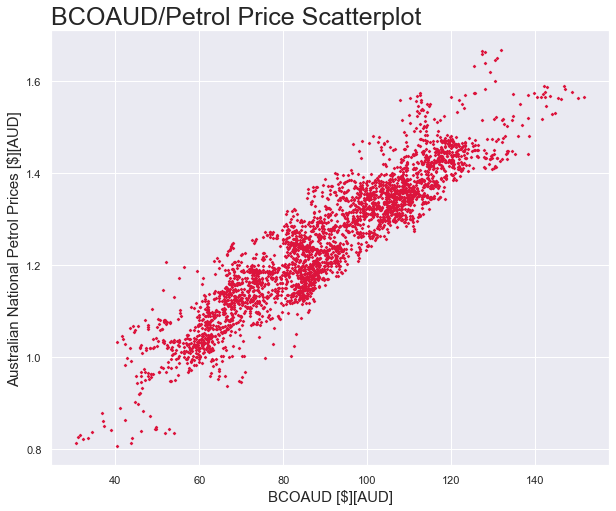

In [41]:
# Next lets look at a preliminary scatterplot, just to see how the relationship looks.
plt.figure(figsize = (10, 8))
plt.scatter(x = x1, y = y, marker = "D", color = "crimson", s = 3)
plt.title(label = "BCOAUD/Petrol Price Scatterplot", fontsize = 25, loc = "left")
plt.xlabel(xlabel = "BCOAUD [$][AUD]", fontsize = 15)
plt.ylabel(ylabel = "Australian National Petrol Prices [$][AUD]", fontsize = 15)
plt.show()

In [42]:
# Would look much nicer if it had more datapoints.

In [43]:
# Now lets create a linear regression model using sklearn.
lin_mod_2 = LinearRegression()

In [44]:
# Sklearn requires a 2-d array(s) as arguments.
x2 = x1.to_numpy().reshape((x1.shape[0], 1))
y2 = y.to_numpy().reshape((y.shape[0], 1))

In [45]:
# Fitting the model.
lin_mod_2.fit(X = x2, y = y2)

LinearRegression()

In [46]:
# R-Squared matched out statsmodels output.
lin_mod_2.score(X = x2, y = y2)

0.857991539734444

## Regression equation: y = b0 + b1x1 + error

In [47]:
# Now lets build the regression equation.
# Also the indexing is so I have floats instead of arrays.
b0 = lin_mod_2.intercept_[0]
b1 = lin_mod_2.coef_[0]
x_in = np.linspace(start = 20, stop = 160, num = 500)

In [48]:
yhat = b0 + b1*x_in

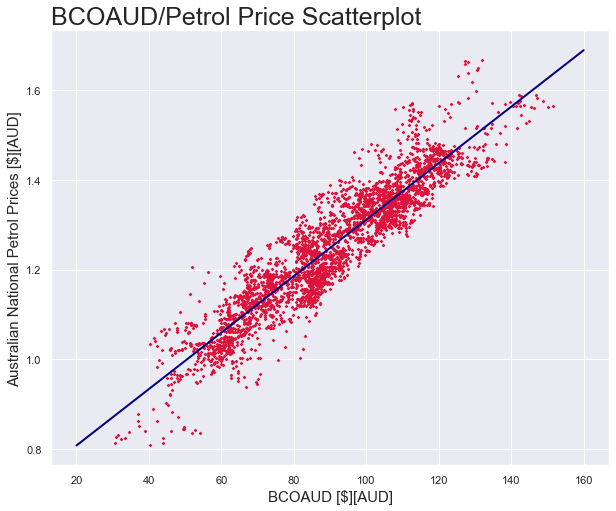

In [49]:
# Now a scatter featuring the linear model.
plt.figure(figsize = (10, 8))
plt.scatter(x = x1, y = y, marker = "D", color = "crimson", s = 3)
plt.plot(x_in, yhat, lw = 2, c = "navy")
plt.title(label = "BCOAUD/Petrol Price Scatterplot", fontsize = 25, loc = "left")
plt.xlabel(xlabel = "BCOAUD [$][AUD]", fontsize = 15)
plt.ylabel(ylabel = "Australian National Petrol Prices [$][AUD]", fontsize = 15)
plt.show()

## Predictions:

In [50]:
# This model can be used to make predictions, can use current BCOAUD prices to figure out roughly where prices will go.
# This is the live brent crude price.
current_brent = brent_df.iloc[-1, 3]
current_brent

126.54000091552734

In [51]:
# Put this into aud as well.
# Live BCOAUD price.
current_brent_aud = current_brent/aud_df.iloc[-1, 3]
current_brent_aud

173.85963926106893

In [52]:
lin_mod_2.predict(X = current_brent_aud.reshape((-1, 1)))[0][0]

1.7773303901625908

## Adjusting the Model to Prevent Underestimation

In [53]:
# Impressive predictions, unfortunately it underestimates the prices.
# Easy fix, just add 20 to 30 cents to the predictions, labelled as "Adjusted Predictions".

petrol_predict = lin_mod_2.predict(X = current_brent_aud.reshape((-1, 1)))[0][0]
petrol_predict_adj = lin_mod_2.predict(X = current_brent_aud.reshape((-1, 1)))[0][0] + 0.30

In [54]:
predict_df = pd.DataFrame(data = {"Simple Prediction [AUD][$]": petrol_predict, "Adjusted Prediction [AUD][$]": petrol_predict_adj}, index = [0])
predict_df

,Simple Prediction [AUD][$],Adjusted Prediction [AUD][$]
0,1.77733,2.07733
